Correlation between reward and decision complexity
Correlation between reward and speed

Speed and decision complexity at given point

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from matplotlib import rcParams
import pickle 
from scipy.signal import medfilt

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

In [ ]:
#color brewer
#d53e4f   red
#fc8d59     orange
#fee08b   yellow
#e6f598  light green
#99d594 green
#3288bd blue

In [3]:
%store -r museum_df
%store -r P
%store -r human_df

In [10]:
# import rewards and policy
%store -r rewards
%store -r policy
%store -r state_map


In [40]:
%store -r museum_df2

In [44]:
%store -r human_df2 

In [22]:
def compute_inst_speed_n(museum_df, nominal_hz=33.0):
    """Computes instantaneous speed assuming fixed sampling rate."""
    df = museum_df.copy(deep=True) 
    speeds = []
    dt = 1.0 / nominal_hz  # assume fixed sampling

    for cluster in range(museum_df.shape[0]):
        x = np.asarray(museum_df.iloc[cluster]['x'])
        y = np.asarray(museum_df.iloc[cluster]['y'])
        dx = np.diff(x)
        dy = np.diff(y)

        v = np.sqrt(dx**2 + dy**2) / dt
        speeds.append(v)

    df['inst_speed'] = speeds
    return df

In [38]:
## Sergei's Speed Function ###




def compute_speed(
    t,
    x,
    y,
    pix_to_m=0.003175,
    window_duration=5.0,
    max_speed=np.inf,
):
    """
    Compute smoothed instantaneous speed from x,y positions and timestamps.

    Parameters
    ----------
    t : array-like
        1D array of timestamps (seconds).
    x, y : array-like
        1D arrays of positions (pixels), same length as t.
    pix_to_m : float
        Pixel-to-meter conversion factor.
    window_duration : float
        Smoothing window duration in seconds for the final moving average.
    max_speed : float
        Maximum plausible speed (values above this are capped).

    Returns
    -------
    speeds_smoothed : np.ndarray
        1D array of smoothed speed estimates (m/s), same length as t.
    """

    # --- 1. Convert to numpy arrays and to meters ---
    t = np.asarray(t, dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    assert t.shape == x.shape == y.shape, "t, x, y must have the same shape"

    x_m = x * pix_to_m
    y_m = y * pix_to_m
    n = len(t)

    # Edge cases
    if n == 0:
        return np.array([], dtype=float)
    if n == 1:
        return np.zeros(1, dtype=float)

    speeds = np.zeros(n, dtype=float)

    # --- 2. Compute raw speeds ---
    # A. Interior points (5-point smoothed central difference, for n >= 5)
    if n >= 5:
        for k in range(2, n - 2):
            dx = (x_m[k + 2] + x_m[k + 1] - x_m[k - 1] - x_m[k - 2]) / 2.0
            dy = (y_m[k + 2] + y_m[k + 1] - y_m[k - 1] - y_m[k - 2]) / 2.0
            dt = (t[k + 2] + t[k + 1] - t[k - 1] - t[k - 2]) / 2.0
            if dt > 0:
                speeds[k] = np.hypot(dx, dy) / dt

    # B. Forward difference for first 2 points
    if n >= 2:
        for k in range(2):  # k = 0, 1
            if k + 1 < n:
                dt = t[k + 1] - t[k]
                if dt > 0:
                    dx = x_m[k + 1] - x_m[k]
                    dy = y_m[k + 1] - y_m[k]
                    speeds[k] = np.hypot(dx, dy) / dt

    # C. Backward difference for last 2 points
    if n >= 3:
        for k in range(n - 2, n):  # k = n-2, n-1
            dt = t[k] - t[k - 1]
            if dt > 0:
                dx = x_m[k] - x_m[k - 1]
                dy = y_m[k] - y_m[k - 1]
                speeds[k] = np.hypot(dx, dy) / dt

    # D. Fallback: simple differences if fewer than 5 points
    if 2 <= n < 5:
        for k in range(n - 1):
            dt = t[k + 1] - t[k]
            if dt > 0:
                dx = x_m[k + 1] - x_m[k]
                dy = y_m[k + 1] - y_m[k]
                speeds[k] = np.hypot(dx, dy) / dt
        speeds[-1] = speeds[-2]  # repeat last value

    # --- 3. Median Filter (3-point) ---
    if n >= 3:
        speeds = medfilt(speeds, kernel_size=3)

    # --- 4. Clean and Cap ---
    # Replace NaN or Inf with 0
    speeds[~np.isfinite(speeds)] = 0.0

    # Enforce non-negativity
    speeds[speeds < 0] = 0.0

    # Cap speeds at the chosen maximum plausible value
    speeds = np.minimum(speeds, max_speed)

    # --- 5. Smooth with Moving Average (~ window_duration seconds) ---
    if n >= 2:
        median_dt = np.median(np.diff(t))
        # Guard against zero or pathological median_dt
        if median_dt <= 0 or not np.isfinite(median_dt):
            # fall back: no extra smoothing
            return speeds

        # Convert smoothing duration into number of samples
        window_size = max(3, int(round(window_duration / median_dt)))

        # Ensure odd window size
        if window_size % 2 == 0:
            window_size += 1

        # Create averaging kernel
        kernel = np.ones(window_size, dtype=float) / window_size

        # Apply moving average
        speeds_smoothed = np.convolve(speeds, kernel, mode='same')
    else:
        # n == 1 case already handled, but just in case
        speeds_smoothed = speeds

    return speeds_smoothed



In [39]:
def compute_inst_speed_new(museum_df,
                           pix_to_m=0.003175,
                           window_duration=5.0,
                           max_speed=np.inf):
    """
    Compute instantaneous speed for each trajectory in museum_df using the
    improved 5-point central-difference speed algorithm.

    Parameters
    ----------
    museum_df : DataFrame
        Each row has columns 'x', 'y', 'time' containing sequences.
    pix_to_m : float
        Conversion factor from pixels to meters.
    window_duration : float
        Smoothing window duration for final moving average (seconds).
    max_speed : float
        Maximum plausible speed (m/s) for capping.

    Returns
    -------
    df : DataFrame
        Copy of museum_df with an added column 'inst_speed'
        containing a NumPy array of smoothed speeds.
    """

    df = museum_df.copy(deep=True)
    speeds_all = []

    for cluster in range(museum_df.shape[0]):

        # Extract values from this trajectory row
        x = np.asarray(museum_df.iloc[cluster]['x'])
        y = np.asarray(museum_df.iloc[cluster]['y'])
        t = np.asarray(museum_df.iloc[cluster]['time'])

        # Compute speed with the new algorithm
        speeds = compute_speed(
            t=t,
            x=x,
            y=y,
            pix_to_m=pix_to_m,
            window_duration=window_duration,
            max_speed=max_speed
        )

        speeds_all.append(speeds)

    df['inst_speed'] = speeds_all
    return df


In [46]:
human_df2

,file,time,x,y,state,visibility
0,20220825_track_00004_AB.csv,"[0.0, 0.03299999999944703, 0.06699999999909778...","[0.6274752499999999, 0.65439925, 0.55768875, 0...","[2.7235467499999997, 2.71897475, 2.711831, 2.7...","[0.09911242603550297, 0.09911242603550297, 0.0...","[8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
1,20220825_track_00006_BA.csv,"[5.833000000002357, 5.866000000001804, 5.90000...","[16.8767125, 16.96234225, 16.97618525, 16.9695...","[9.51938025, 9.5390335, 9.52687325, 9.54909825...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,20220825_track_00010_AB.csv,"[0.7000000000007276, 0.7330000000001746, 0.765...","[0.408686, 0.6739255, 0.6202362499999999, 0.38...","[3.4189352499999996, 3.35353025, 3.4455735, 3....","[0.17825443786982248, 0.17899408284023668, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 8, ..."
3,20220825_track_00017_BA.csv,"[4.766999999999825, 4.799999999999272, 4.83300...","[16.78905075, 16.96856525, 16.725265, 16.93475...","[9.2076905, 9.27592125, 9.32195875, 9.547352, ...","[0.9607988165680473, 0.9615384615384616, 0.993...","[10, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9,..."
4,20220825_track_00031_BA.csv,"[2.7339999999967404, 2.7669999999998254, 2.799...","[16.78530425, 16.780129, 16.7749855, 16.769810...","[9.5833565, 9.56497325, 9.5465265, 9.52807975,...","[0.9933431952662722, 0.9933431952662722, 0.993...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
...,...,...,...,...,...,...
95,20220825_track_02117_AB.csv,"[0.0, 0.033000000003085006, 0.0670000000027357...","[1.601978, 1.608582, 1.61483675, 1.6280765, 1....","[2.300732, 2.3040975, 2.30724075, 2.29269925, ...","[0.03106508875739645, 0.03106508875739645, 0.0...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
96,20220826_track_00008_BB.csv,"[8.399999999999636, 8.932999999999993, 8.96699...","[16.91522525, 16.82842075, 16.8265475, 16.8188...","[9.59983475, 9.59450075, 9.54935225, 9.5478917...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, ..."
97,20220826_track_00013_BA.csv,"[18.46600000000035, 18.5, 18.533000000000357, ...","[16.38023775, 16.37928525, 16.37833275, 16.560...","[9.596405749999999, 9.58618225, 9.575927, 9.40...","[0.992603550295858, 0.992603550295858, 0.99260...","[8, 8, 8, 8, 9, 8, 10, 10, 9, 10, 8, 9, 9, 9, ..."
98,20220826_track_00030_AB.csv,"[1.0, 1.032999999999447, 1.065999999998894, 1....","[0.30210125, 0.43345100000000003, 0.5087302499...","[3.7237987499999994, 3.6714747499999993, 3.675...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."


In [49]:
human_df2 = compute_inst_speed_new(human_df2)

In [50]:
human_df2

,file,time,x,y,state,visibility,inst_speed
0,20220825_track_00004_AB.csv,"[0.0, 0.03299999999944703, 0.06699999999909778...","[0.6274752499999999, 0.65439925, 0.55768875, 0...","[2.7235467499999997, 2.71897475, 2.711831, 2.7...","[0.09911242603550297, 0.09911242603550297, 0.0...","[8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.0011529439414024783, 0.0011666930155378365,..."
1,20220825_track_00006_BA.csv,"[5.833000000002357, 5.866000000001804, 5.90000...","[16.8767125, 16.96234225, 16.97618525, 16.9695...","[9.51938025, 9.5390335, 9.52687325, 9.54909825...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[0.001142848420490951, 0.0011656370573946099, ..."
2,20220825_track_00010_AB.csv,"[0.7000000000007276, 0.7330000000001746, 0.765...","[0.408686, 0.6739255, 0.6202362499999999, 0.38...","[3.4189352499999996, 3.35353025, 3.4455735, 3....","[0.17825443786982248, 0.17899408284023668, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 8, ...","[0.002337474824928296, 0.002357426166328938, 0..."
3,20220825_track_00017_BA.csv,"[4.766999999999825, 4.799999999999272, 4.83300...","[16.78905075, 16.96856525, 16.725265, 16.93475...","[9.2076905, 9.27592125, 9.32195875, 9.547352, ...","[0.9607988165680473, 0.9615384615384616, 0.993...","[10, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9,...","[0.0033348359238922496, 0.0033445375044368173,..."
4,20220825_track_00031_BA.csv,"[2.7339999999967404, 2.7669999999998254, 2.799...","[16.78530425, 16.780129, 16.7749855, 16.769810...","[9.5833565, 9.56497325, 9.5465265, 9.52807975,...","[0.9933431952662722, 0.9933431952662722, 0.993...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.0008864491229871226, 0.0008938964948621892,..."
...,...,...,...,...,...,...,...
95,20220825_track_02117_AB.csv,"[0.0, 0.033000000003085006, 0.0670000000027357...","[1.601978, 1.608582, 1.61483675, 1.6280765, 1....","[2.300732, 2.3040975, 2.30724075, 2.29269925, ...","[0.03106508875739645, 0.03106508875739645, 0.0...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0.00011501146990330927, 0.0001151215712470359..."
96,20220826_track_00008_BB.csv,"[8.399999999999636, 8.932999999999993, 8.96699...","[16.91522525, 16.82842075, 16.8265475, 16.8188...","[9.59983475, 9.59450075, 9.54935225, 9.5478917...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, ...","[0.001302657764858728, 0.0013085008203126793, ..."
97,20220826_track_00013_BA.csv,"[18.46600000000035, 18.5, 18.533000000000357, ...","[16.38023775, 16.37928525, 16.37833275, 16.560...","[9.596405749999999, 9.58618225, 9.575927, 9.40...","[0.992603550295858, 0.992603550295858, 0.99260...","[8, 8, 8, 8, 9, 8, 10, 10, 9, 10, 8, 9, 9, 9, ...","[0.002228374989892665, 0.0022564545116238906, ..."
98,20220826_track_00030_AB.csv,"[1.0, 1.032999999999447, 1.065999999998894, 1....","[0.30210125, 0.43345100000000003, 0.5087302499...","[3.7237987499999994, 3.6714747499999993, 3.675...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0.0021517033642784035, 0.002182189523353032, ..."


In [23]:
%store -r museum_df2

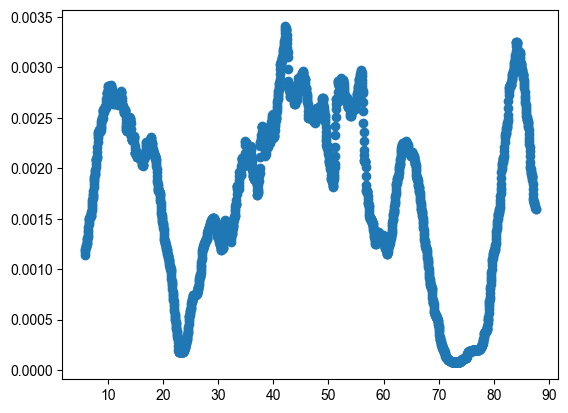

In [52]:
fig, ax = plt.subplots()

ax.scatter(x = human_df2.iloc[1]['time'], y = human_df2.iloc[1]['inst_speed'])

# alternative instantaneous speed df

In [32]:
threshold = 1.5
cleaned_human_df = human_df2.copy()

main = ["time", "x", "y", "state", "visibility"]  # length L
speed = "inst_speed"                               # length L-1

for i, row in cleaned_human_df.iterrows():
    # Trim all main columns to a common L
    L = min(len(row[c]) for c in main)
    arrays = {c: list(row[c])[:L] for c in main}

    # Trim inst_speed to at most L-1
    sp = list(row[speed])[:max(L-1, 0)]

    # Build keep flags for main columns: first True, then compare to sp
    keep = [True] + [v <= threshold for v in sp]   # length L

    # Apply keep to main columns
    for c in main:
        cleaned_human_df.at[i, c] = [a for a, k in zip(arrays[c], keep) if k]

    # Filter inst_speed itself
    cleaned_human_df.at[i, speed] = [v for v in sp if v <= threshold]


In [33]:
cleaned_human_df

,file,time,x,y,state,visibility,inst_speed
0,20220825_track_00004_AB.csv,"[0.0, 0.03299999999944703, 0.13300000000162981...","[0.6274752499999999, 0.65439925, 0.74733149999...","[2.7235467499999997, 2.71897475, 2.6899235, 2....","[0.09911242603550297, 0.09911242603550297, 0.0...","[8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.9012111858160656, 1.4712801571084473, 1.137..."
1,20220825_track_00006_BA.csv,"[5.833000000002357, 5.900000000001455, 5.93300...","[16.8767125, 16.97618525, 16.969517749999998, ...","[9.51938025, 9.52687325, 9.54909825, 9.5260795...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[0.608042645173122, 0.7657181801298147, 0.7634..."
2,20220825_track_00010_AB.csv,"[0.7000000000007276, 0.8660000000018044, 1.0, ...","[0.408686, 0.30222825, 0.46485174999999995, 0....","[3.4189352499999996, 3.5260914999999997, 3.512...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 7, 8, 8, 8, 9, 8, 8, 8, 8, 8, ...","[0.5617757630297087, 1.3748783738935104, 1.009..."
3,20220825_track_00017_BA.csv,"[4.766999999999825, 4.900000000001455, 4.93300...","[16.78905075, 16.91611425, 16.936497749999997,...","[9.2076905, 9.513443, 9.50998225, 9.4914085, 9...","[0.9607988165680473, 0.9940828402366864, 0.994...","[10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9,...","[1.2768771532001149, 0.682281574280525, 1.0249..."
4,20220825_track_00031_BA.csv,"[2.7339999999967404, 2.7669999999998254, 2.799...","[16.78530425, 16.780129, 16.7749855, 16.769810...","[9.5833565, 9.56497325, 9.5465265, 9.52807975,...","[0.9933431952662722, 0.9933431952662722, 0.993...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.6302283748080368, 0.6319635081535644, 0.632..."
...,...,...,...,...,...,...,...
95,20220825_track_02117_AB.csv,"[0.0, 0.033000000003085006, 0.0670000000027357...","[1.601978, 1.608582, 1.61483675, 1.6280765, 1....","[2.300732, 2.3040975, 2.30724075, 2.29269925, ...","[0.03106508875739645, 0.03106508875739645, 0.0...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0.24459970033966058, 0.23100452125039825, 0.6..."
96,20220826_track_00008_BB.csv,"[8.399999999999636, 8.966999999999643, 9.0, 9....","[16.91522525, 16.8265475, 16.8188005, 16.82594...","[9.59983475, 9.54935225, 9.54789175, 9.519666,...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[1.4911823739227172, 0.26015444722949443, 0.96..."
97,20220826_track_00013_BA.csv,"[18.46600000000035, 18.5, 18.533000000000357, ...","[16.38023775, 16.37928525, 16.37833275, 16.546...","[9.596405749999999, 9.58618225, 9.575927, 9.28...","[0.992603550295858, 0.992603550295858, 0.99260...","[8, 8, 8, 10, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[0.3388365831141463, 0.33987982905258857, 0.53..."
98,20220826_track_00030_AB.csv,"[1.0, 1.0999999999985448, 1.1329999999998108, ...","[0.30210125, 0.52758975, 0.553847, 0.52479575,...","[3.7237987499999994, 3.7079872499999995, 3.691...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, ...","[1.2412459483504084, 1.029159870924729, 1.0249..."


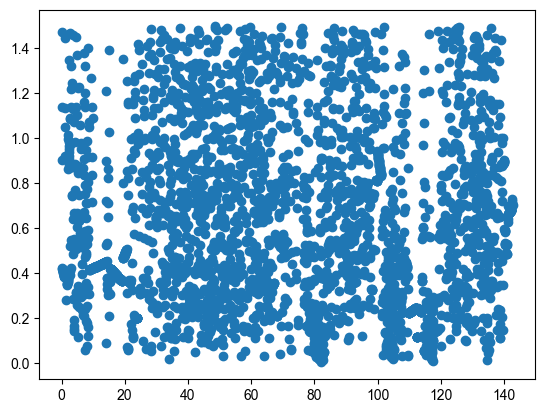

In [35]:
fig, ax = plt.subplots()

ax.scatter(x = cleaned_human_df.iloc[0]['time'][1:], y = cleaned_human_df.iloc[0]['inst_speed'])

# plot cleaned df

In [37]:
del museum_df

In [13]:
del human_df

In [42]:
del museum_df

In [43]:
%store -r museum_df

In [6]:
museum_df

,file,time,x,y,state,visibility
0,cluster_001.csv,"[0.0, 9.45179584120983e-05, 0.0001890359168241...","[0.6086956521739131, 0.6086956521739131, 0.608...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.20857988165680474, 0.20857988165680474, 0.2...","[11, 11, 11, 12, 12, 12, 11, 11, 12, 12, 12, 1..."
1,cluster_002.csv,"[0.0, 3.066638044711583e-05, 6.133276089423166...","[0.8695652173913043, 0.8695652173913043, 0.869...","[0.16216216216216217, 0.16216216216216217, 0.1...","[0.9644970414201184, 0.9644970414201184, 0.964...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
2,cluster_003.csv,"[0.02491408934707904, 0.02534364261168385, 0.0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
3,cluster_004.csv,"[0.0, 0.0004803073967339097, 0.000960614793467...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.14127218934911243, 0.14127218934911243, 0.1...","[10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 9, ..."
4,cluster_007.csv,"[0.007297433316557625, 0.007800704579768495, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, ..."
5,cluster_009.csv,"[0.0019734987313222443, 0.002537355511700028, ...","[0.014492753623188406, 0.014492753623188406, 0...","[0.7567567567567568, 0.7567567567567568, 0.756...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 7, 7, 7, 7, 7, ..."
6,cluster_012.csv,"[0.001634827888952802, 0.001695377070025128, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6216216216216216, 0.621...","[0.21819526627218935, 0.2581360946745562, 0.25...","[7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
7,cluster_017.csv,"[0.012419006479481642, 0.01259899208063355, 0....","[0.014492753623188406, 0.014492753623188406, 0...","[0.7567567567567568, 0.7567567567567568, 0.756...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 8, ..."
8,cluster_018.csv,"[0.011353232008789599, 0.011719465299395715, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6486486486486487, 0.648...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, ..."
9,cluster_021.csv,"[0.00866113316492241, 0.009022013713460845, 0....","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, ..."


In [7]:
np.array(museum_df.iloc[0]['x']) * state_map.T.shape[0] 

array([42., 42., 42., ...,  3.,  3.,  2.], shape=(10289,))

In [ ]:
# use human_df to calculate instantaneous speed threshold based on real x and y coordinates
# remove the 1.5 m/s thresholding from the idx values in museum df
# plot the cleaned traces of museum df

def dist_clean_plot_heatmap(museum_df, human_df, state_map, cluster_idx, bins= 50 ):
    """
    Cleans museum_df based on instantaneous speed threshold derived from human_df, plots the cleaned traces.
    Reduces the number of x,y points that are in the same location by the reduce_factor.
    """
    museum_df_cleaned = museum_df.copy(deep=True)

    #compute instantaneous speed in human df
    human_inst_speed_df = compute_inst_speed_n(human_df, nominal_hz=33.0)

    #clean up human df based on speed threshold
    threshold = 1.5
    main = ["time", "x", "y", "state", "visibility"]  # length L
    speed = "inst_speed"                               # length L-1

    for i, row in human_inst_speed_df.iterrows():
        # Trim all main columns to a common L
        # use museum_df_cleaned (normalized) for coordinates
        L = min(len(museum_df_cleaned.at[i, c]) for c in main)
        arrays = {c: list(museum_df_cleaned.at[i, c])[:L] for c in main}  # ✅ use museum data
        sp = list(human_inst_speed_df.at[i, speed])[:max(L-1, 0)] 
        # Build keep flags for main columns: first True, then compare to sp
        keep = [True] + [v <= threshold for v in sp]   # length L

        # Apply keep to main columns, in the museum_df now!
        for c in main:
            museum_df_cleaned.at[i, c] = [a for a, k in zip(arrays[c], keep) if k]

    # plot the cleaned museum_df traces, these have x y points that are normalized, so unnormalize first

    W,H = state_map.T.shape
    x_s = np.array(museum_df_cleaned.iloc[cluster_idx]['x'])
    y_s = np.array(museum_df_cleaned.iloc[cluster_idx]['y'])
    #x /W y/H originally 

    x_s = x_s * W
    print(len(x_s))
    y_s = y_s * H
    print(len(y_s))

    plt.figure(figsize=(10, 6))
    # plot histogram
    h = plt.hist2d(x_s, y_s, bins=bins, cmap="viridis")
    cbar = plt.colorbar(h[3])
    cbar.set_label("Frequency")


    cluster_name = museum_df.iloc[cluster_idx]["file"]

    plt.scatter(x_s, y_s,  cmap="viridis", s=12, alpha=0.8)
    # Overlay the -1 regions from state_map
    obstacles = np.where(np.flipud(state_map) == -1)
    plt.scatter(obstacles[1], obstacles[0], color="lightgray", s=10, alpha=0.6, label="Walls")
    plt.gca().invert_yaxis()
    # plt.colorbar(scatter, label="Time bin")
    plt.xlabel("X (normalized)")
    plt.ylabel("Y (normalized)")
    plt.title(f"All Features for {cluster_name}")
    plt.tight_layout()
    plt.show()
    



    

3338
3338


/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_8746/2112667470.py:51: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_s, y_s,  cmap="viridis", s=12, alpha=0.8)


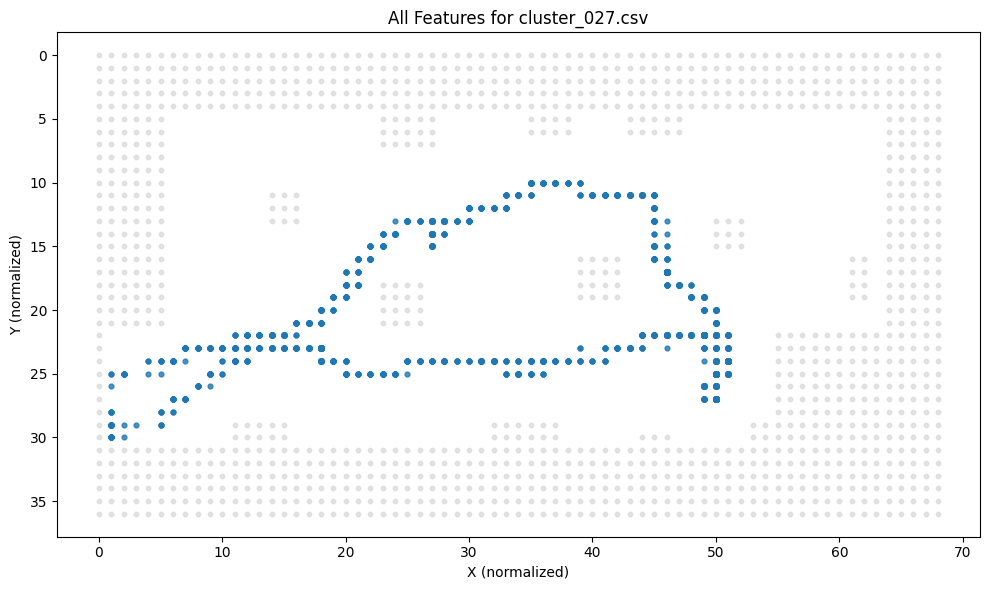

In [20]:
dist_clean_plot(museum_df, human_df, state_map, cluster_idx = 12 )

In [12]:

def _downsample_lists_df(df, cols, k):
    out = df.copy(deep=True)
    for i, row in out.iterrows():
        for c in cols:
            out.at[i, c] = list(row[c])[::k]
    return out

In [6]:
%store -r museum_df2
%store -r human_df2

In [8]:
# use human_df to calculate instantaneous speed threshold based on real x and y coordinates
# remove the 1.5 m/s thresholding from the idx values in museum df
# plot the cleaned traces of museum df

def dist_clean_plot_downsample(museum_df, human_df, state_map, cluster_idx, reduce_factor=5 ):
    """
    Cleans museum_df based on instantaneous speed threshold derived from human_df, plots the cleaned traces.
    Reduces the number of x,y points that are in the same location by the reduce_factor.
    """
    main = ["time", "x", "y", "state", "visibility"]  # length L

    # reduce sampling in entire dataframe
    # 1) downsample BOTH dataframes identically
    museum_ds = _downsample_lists_df(museum_df, main, reduce_factor)
    human_ds  = _downsample_lists_df(human_df,  main, reduce_factor)


    #compute instantaneous speed in human df
    human_inst_speed_df = compute_inst_speed_n(human_ds, nominal_hz=33.0/ reduce_factor) #uses a copy of human_df anyway

    #clean up human df based on speed threshold
    threshold = 1.5


    museum_clean = museum_ds.copy(deep=True)

    speed = "inst_speed"                               # length L-1

    for i, row in human_inst_speed_df.iterrows():
        # Trim all main columns to a common L
        # use museum_df_cleaned (normalized) for coordinates
        L = min(len( museum_clean.at[i, c]) for c in main)
        arrays = {c: list(museum_clean.at[i, c])[:L] for c in main}  # ✅ use museum data
        sp = list(human_inst_speed_df.at[i, speed])[:max(L-1, 0)] 
        # Build keep flags for main columns: first True, then compare to sp
        keep = [True] + [v <= threshold for v in sp]   # length L

        # Apply keep to main columns, in the museum_df now!
        for c in main:
            museum_clean.at[i, c] = [a for a, k in zip(arrays[c], keep) if k]

    # plot the cleaned museum_df traces, these have x y points that are normalized, so unnormalize first

    W,H = state_map.T.shape
    x_s = np.array(museum_clean.iloc[cluster_idx]['x'])
    y_s = np.array(museum_clean.iloc[cluster_idx]['y'])
    #x /W y/H originally 

    x_s = x_s * W
    print(len(x_s))
    y_s = y_s * H
    print(len(y_s))

    plt.figure(figsize=(10, 6))



    cluster_name = museum_df.iloc[cluster_idx]["file"]

    plt.scatter(x_s, y_s,  cmap="viridis", s=12, alpha=0.8)
    # Overlay the -1 regions from state_map
    obstacles = np.where(np.flipud(state_map) == -1)
    plt.scatter(obstacles[1], obstacles[0], color="lightgray", s=10, alpha=0.6, label="Walls")
    plt.gca().invert_yaxis()
    # plt.colorbar(scatter, label="Time bin")
    plt.xlabel("X (normalized)")
    plt.ylabel("Y (normalized)")
    plt.title(f"All Features for {cluster_name}")
    plt.tight_layout()
    plt.show()

    return museum_clean
    



    

In [51]:
# use human_df to calculate instantaneous speed threshold based on real x and y coordinates
# remove the 1.5 m/s thresholding from the idx values in museum df
# plot the cleaned traces of museum df
# add memory column to main

def dist_clean_plot_downsample_w_mem(museum_df_w_mem, human_df, state_map, cluster_idx, reduce_factor=5 ):
    """
    Cleans museum_df based on instantaneous speed threshold derived from human_df, plots the cleaned traces.
    Reduces the number of x,y points that are in the same location by the reduce_factor.
    """
    main = ["time", "x", "y", "state", "visibility"]  # length L
    main_w_mem = ["time", "x", "y", "state", "visibility", "memory"]  # length L

    # reduce sampling in entire dataframe
    # 1) downsample BOTH dataframes identically, but museum has memory column
    museum_ds = _downsample_lists_df(museum_df_w_mem, main_w_mem, reduce_factor)
    human_ds  = _downsample_lists_df(human_df,  main, reduce_factor)


    #compute instantaneous speed in human df
    human_inst_speed_df = compute_inst_speed_n(human_ds, nominal_hz=33.0/ reduce_factor) #uses a copy of human_df anyway

    #clean up human df based on speed threshold
    threshold = 1.5


    museum_clean = museum_ds.copy(deep=True)

    speed = "inst_speed"                               # length L-1

    for i, row in human_inst_speed_df.iterrows():
        # Trim all main columns to a common L
        # use museum_df_cleaned (normalized) for coordinates
        L = min(len( museum_clean.at[i, c]) for c in main_w_mem)
        arrays = {c: list(museum_clean.at[i, c])[:L] for c in main_w_mem}  #  use museum data
        sp = list(human_inst_speed_df.at[i, speed])[:max(L-1, 0)] 
        # Build keep flags for main columns: first True, then compare to sp
        keep = [True] + [v <= threshold for v in sp]   # length L

        # Apply keep to main columns, in the museum_df_w_mem now!
        for c in main_w_mem:
            museum_clean.at[i, c] = [a for a, k in zip(arrays[c], keep) if k]

    # plot the cleaned museum_df traces, these have x y points that are normalized, so unnormalize first

    W,H = state_map.T.shape
    x_s = np.array(museum_clean.iloc[cluster_idx]['x'])
    y_s = np.array(museum_clean.iloc[cluster_idx]['y'])
    #x /W y/H originally 

    x_s = x_s * W
    print(len(x_s))
    y_s = y_s * H
    print(len(y_s))

    plt.figure(figsize=(10, 6))



    cluster_name = museum_df_w_mem.iloc[cluster_idx]["file"]

    plt.scatter(x_s, y_s,  cmap="viridis", s=12, alpha=0.8)
    # Overlay the -1 regions from state_map
    obstacles = np.where(np.flipud(state_map) == -1)
    plt.scatter(obstacles[1], obstacles[0], color="lightgray", s=10, alpha=0.6, label="Walls")
    plt.gca().invert_yaxis()
    # plt.colorbar(scatter, label="Time bin")
    plt.xlabel("X (normalized)")
    plt.ylabel("Y (normalized)")
    plt.title(f"All Features for {cluster_name}")
    plt.tight_layout()
    plt.show()

    return museum_clean
    



    

In [52]:
%store -r museum_df_w_actions

866
866


/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_8746/4103281526.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_s, y_s,  cmap="viridis", s=12, alpha=0.8)


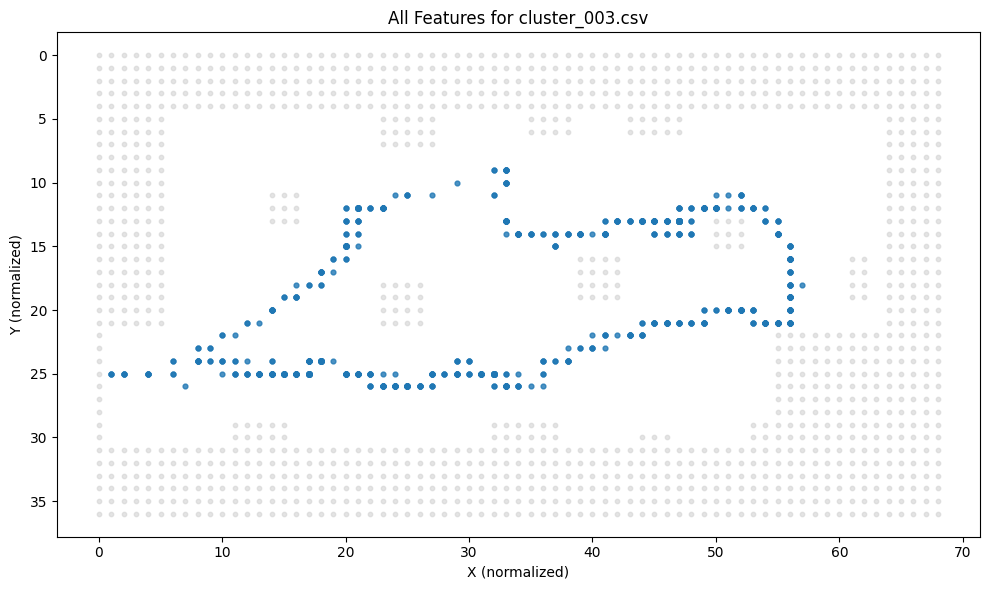

In [67]:
museum_df_w_mem_cleaned = dist_clean_plot_downsample_w_mem(museum_df_w_actions, human_df, state_map, cluster_idx= 2, reduce_factor=2 )

In [56]:
%store museum_df_w_mem_cleaned

Stored 'museum_df_w_mem_cleaned' (DataFrame)


In [34]:
len(museum_df.iloc[1]['x'])

32172

2656
2656


/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_88257/3445925243.py:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_s, y_s,  cmap="viridis", s=12, alpha=0.8)


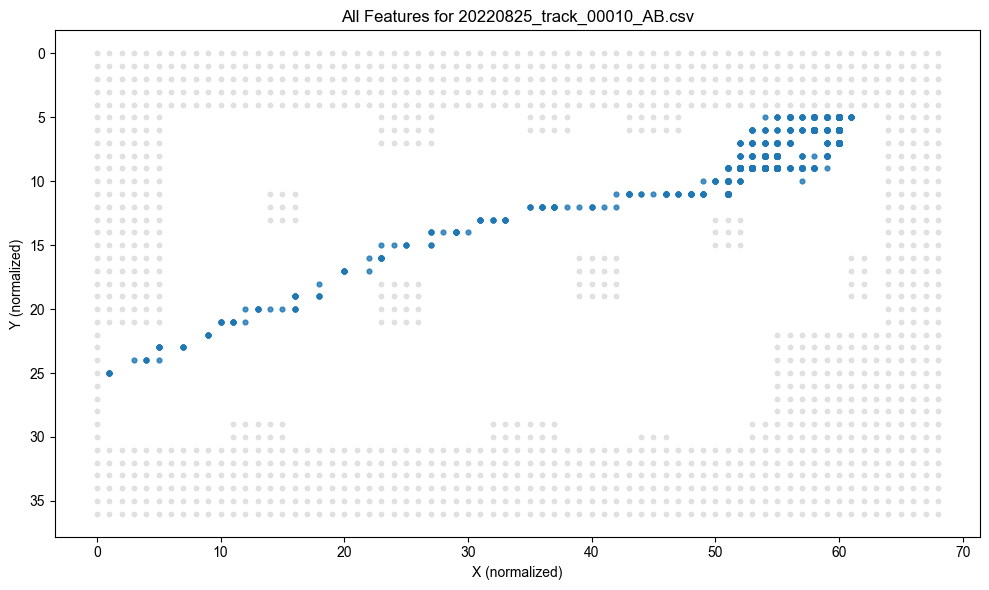

In [15]:
museum_df_cleaned2 = dist_clean_plot_downsample(museum_df2, human_df2, state_map, cluster_idx= 2, reduce_factor=1 )

In [16]:
%store museum_df_cleaned2

Stored 'museum_df_cleaned2' (DataFrame)


In [19]:
with open("stored_vars.pkl", "rb") as f:
    stored = pickle.load(f)

In [20]:
stored["museum_df_cleaned2"] = museum_df_cleaned2

In [21]:
with open("stored_vars.pkl", "wb") as f:
    pickle.dump(stored, f)

In [41]:
%store museum_df_cleaned

Stored 'museum_df_cleaned' (DataFrame)


In [21]:
# attribute inst_speed to rewards
#inst speed is associated with state_arr + 1
def speed_v_reward(rewards, museum_df, state_map):
    nstates = state_map.max() + 1
    reward_states = rewards[0: nstates]
     # Fill each spatial location
    final_rewards = np.zeros(state_map.T.shape)
    for s in range(nstates):
        r = reward_states[s]
        x = np.where(np.flipud(state_map).T == s)[0][0]
        y = np.where(np.flipud(state_map).T == s)[1][0]
        final_rewards[x][y] = r

    
    

    # precompute (x, y) for each state (same convention as above)
    xy_for_state = np.full((nstates, 2), -1, dtype=int)
    for s in range(nstates):
        x = np.where(np.flipud(state_map).T == s)[0][0]
        y = np.where(np.flipud(state_map).T == s)[1][0]
        xy_for_state[s] = (x, y)

    rows = []

    for cluster, row in museum_df.iterrows():
        speed_arr = row['inst_speed']
        
        state_arr_norm = np.array(row['state'])
        #undo normalization
        state_arr = np.clip((state_arr_norm * nstates).astype(int), 0, nstates - 1)
        #find where on state_map each element of state_arr is located, and grab corresponding reward from final_rewards, AND its inst_speed
        # ensure consistent lengths: use transitions up to min(len(speed)+1, len(state))
        L = min(len(state_arr), len(speed_arr) + 1)
        state_arr = state_arr[:L]
        speed_arr = speed_arr[:(L - 1)]  # matches transitions t=0..L-2

        for t in range(L - 1):
            s_next = int(state_arr[t + 1])          # arrival state
            x, y = xy_for_state[s_next] #find its coordinates
            r = float(final_rewards[x, y])
            v = float(speed_arr[t])


            rows.append({
                        'cluster': cluster,
                        't_idx': t + 1,      # index of the arrival state
                        'state': s_next,
                        'x': int(x),
                        'y': int(y),
                        'reward': r,
                        'inst_speed': v,
            })

    return pd.DataFrame(rows)


    

   


In [22]:
speeds = speed_v_reward(rewards, cleaned_human_df, state_map)

In [23]:
speeds

,cluster,t_idx,state,x,y,reward,inst_speed
0,0,1,283,43,25,765.993346,1.356786
1,0,2,283,43,25,765.993346,1.437366
2,0,3,283,43,25,765.993346,0.770648
3,0,4,284,44,25,766.095431,0.239383
4,0,5,284,44,25,766.095431,0.743903
...,...,...,...,...,...,...,...
95479,12,3333,38,1,29,446.260532,1.406438
95480,12,3334,79,1,28,509.327939,0.758447
95481,12,3335,79,1,28,509.327939,0.729543
95482,12,3336,79,1,28,509.327939,0.852679


In [24]:
# Drop NaNs and infs
df = speeds.replace([np.inf, -np.inf], np.nan).dropna(subset=['inst_speed','reward'])

# Compute correlation
rho, p = spearmanr(df['inst_speed'], df['reward'], nan_policy='omit')

# compute pearson correlation
r, p_pearson = pearsonr(df['inst_speed'], df['reward'])

Text(0.05, 0.95, 'Spearman ρ = 0.117\nP = 1.9e-290\nPearson r = 0.169\nP = 0.0e+00')

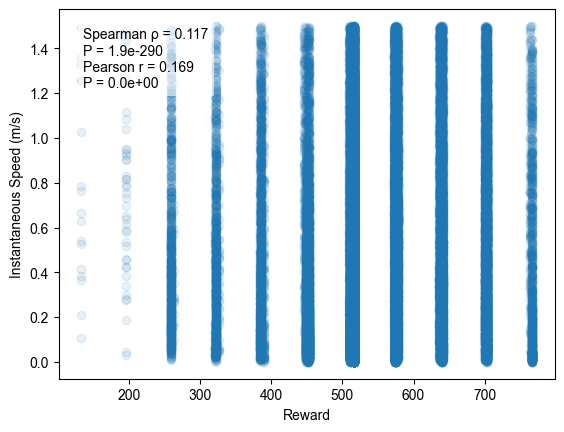

In [25]:
# plot speed correlated with reward
fig, ax = plt.subplots()
ax.scatter(x = speeds['reward'], y = speeds['inst_speed'], alpha=0.1)
ax.set_xlabel('Reward')
ax.set_ylabel('Instantaneous Speed (m/s)')

#stats
# Add correlation text box in upper-left corner
textstr = f"Spearman ρ = {rho:.3f}\nP = {p:.1e}"
textstr += f"\nPearson r = {r:.3f}\nP = {p_pearson:.1e}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# plt.savefig('/Users/iuliarusu/Documents/museum/images/grant_images/speedvreward.svg', format='svg', bbox_inches='tight')


In [150]:
compute_inst_speed(human_df)

10289
10289
10289
32172
32172
32172
2265
2265
2265
1990
1990
1990
3893
3893
3893
7021
7021
7021
32182
32182
32182
5487
5487
5487
5349
5349
5349
2691
2691
2691
2454
2454
2454
2797
2797
2797
3969
3969
3969


,file,time,x,y,state,visibility,inst_speed
0,cluster_001.csv,"[0.0, 0.029999999999972715, 0.0699999999999931...","[12.6850775, 12.70762, 12.812395, 12.919709999...","[3.5356799999999997, 3.4769424999999994, 3.460...","[0.20857988165680474, 0.20857988165680474, 0.2...","[11, 11, 11, 12, 12, 12, 11, 11, 12, 12, 12, 1...","[2.097156331932268, 2.651695297940131, 3.62421..."
1,cluster_002.csv,"[0.0, 0.03330000000000011, 0.06669999999999998...","[18.253075, 18.2508525, 18.255615, 18.25752, 1...","[9.290367499999999, 9.288145, 9.2837, 9.28624,...","[0.9644970414201184, 0.9644970414201184, 0.964...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.09438707634750805, 0.19504656700167564, 0.0..."
2,cluster_003.csv,"[1.9700000000000273, 2.0, 2.07000000000005, 2....","[0.308124225, 0.32375475, 0.32442150000000003,...","[3.4820225, 3.5080575, 3.5398075, 3.5499674999...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[1.0122222728988792, 0.4536714300471594, 0.397..."
3,cluster_004.csv,"[0.0, 0.029999999999972715, 0.0699999999999363...","[1.6986567499999998, 1.7238980000000002, 1.788...","[3.0757494999999997, 3.1001334999999997, 3.066...","[0.14127218934911243, 0.14127218934911243, 0.1...","[10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 9, ...","[1.1698528670852184, 1.8289124789103133, 2.219..."
4,cluster_007.csv,"[1.8700000000000045, 1.9300000000000637, 2.0, ...","[0.316169675, 0.36058474999999995, 0.407733499...","[3.14861575, 3.11661175, 3.165729, 3.12334275,...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.9124075148336493, 0.9726367354829336, 1.480..."
5,cluster_009.csv,"[1.0, 1.2000000000000455, 1.2000000000000455, ...","[0.33035875, 0.44992925, 0.490093, 0.5645785, ...","[2.49443875, 2.49951875, 2.49208925, 2.477643,...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 7, 7, 7, 7, 7, ...","[0.598391821264368, nan, nan, 0.23865632556270..."
6,cluster_012.csv,"[2.160000000000082, 2.330000000000041, 2.36000...","[0.32524699999999995, 0.38750874999999996, 0.3...","[3.8214299999999994, 3.921125, 3.9296975, 3.90...","[0.21819526627218935, 0.2581360946745562, 0.25...","[7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.6914109374042748, 0.9913985163024946, 2.290..."
7,cluster_017.csv,"[2.800000000000182, 2.800000000000182, 2.80000...","[0.38331775, 0.50263425, 0.5069205, 0.5405755,...","[2.6600149999999996, 2.6322337499999997, 2.607...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 8, ...","[nan, nan, 0.3375555120646192, nan, nan, 1.286..."
8,cluster_018.csv,"[3.0, 3.099999999999909, 3.199999999999818, 3....","[0.306466875, 0.305520725, 0.437134, 0.3511867...","[3.8728649999999996, 3.8827075, 3.8655625, 3.8...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, ...","[0.09887871665464018, 1.3272529970302451, nan,..."
9,cluster_021.csv,"[2.2000000000000455, 2.2999999999999545, 2.299...","[0.314867925, 0.35264724999999997, 0.34699575,...","[3.08473475, 3.1008954999999996, 3.11985025, 3...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, ...","[0.41090719609434706, nan, nan, 0.407694830512..."


# P(s) and Decision Complexity Calculations

In [26]:
# P(s)

#get probability of state using time probability
def build_policy_transition_matrix(P, policy):
    """Built s_next by s matrix"""
    n_states = len(P)
    n_actions = policy.shape[1]
    P_pi = np.zeros((n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for prob, s_next, _, _ in P[s][a]:
                P_pi[s, s_next] += policy[s, a] * prob
    return P_pi


def compute_state_distribution(P, policy, s0, T):
    """Compute state distribution after T steps from s0 under policy."""
    n_states = len(P)
    P_pi = build_policy_transition_matrix(P, policy)
    initial_dist = np.zeros(n_states)
    initial_dist[s0] = 1.0
    P_pi_T = np.linalg.matrix_power(P_pi, T)
    P_s = initial_dist @ P_pi_T
    assert np.isclose(P_s.sum(), 1.0), f"Not normalized: {P_s.sum()}"
    return P_s



In [27]:
# Build P_pi
P_pi = build_policy_transition_matrix(P, policy)

# Distribution after 10 steps starting from state 0
P_s = compute_state_distribution(P, policy, s0=0, T=10)
print(P_s)  # vector of length n_states

[3.79856553e-109 3.38617480e-101 7.39082404e-094 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


In [28]:

def plot_state_distribution(P_s, state_map, title="State distribution"):
    # MiniGrid-style map: (x,y)
    canonical_map = state_map.T          # shape = (W, H)
    W, H = canonical_map.shape

    # Build grid as (H, W): rows=y, cols=x
    grid = np.full((H, W), np.nan, dtype=float)
    for x in range(W):
        for y in range(H):
            s = canonical_map[x, y]
            if s >= 0:
                grid[y, x] = P_s[s]

    plt.figure(figsize=(6, 6))
    # extent ensures axes go 0..W and 0..H; origin='lower' -> (0,0) bottom-left
    plt.imshow(grid, origin="lower", cmap="viridis",
               extent=[0, W, 0, H], interpolation="nearest", aspect="equal")
    plt.colorbar(label="Probability")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, W)
    plt.ylim(0, H)
    plt.show()

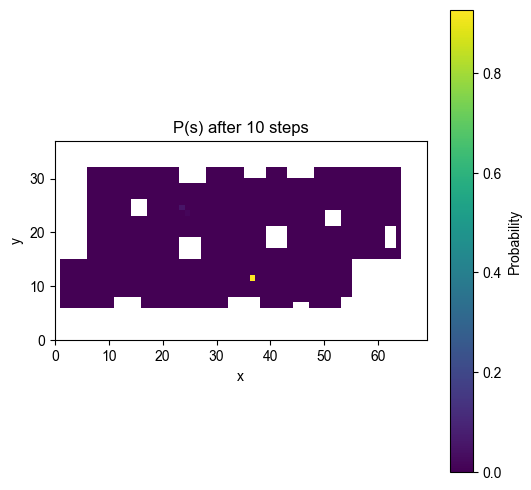

In [29]:
P_s = compute_state_distribution(P, policy, s0=0, T=40)
plot_state_distribution(P_s, state_map, title="P(s) after 10 steps")


In [30]:
#calculate desision complexity
# pi(a)
def get_Pi_a(P, policy, s0, T):
    """
    Compute marginal action distribution π(a) after T steps.
    """
    # State distribution at T
    P_s = compute_state_distribution(P, policy, s0, T)

    # Weighted average of π(a|s) across states
    pi_a = np.sum(P_s[:, None] * policy, axis=0)

    # Normalize (safety)
    pi_a /= pi_a.sum()
    return pi_a

def get_decision(P, policy, s0, T):
    """
    Compute decision terms through time (like relative entropy).
    """
    decisions = []
    for t in range(T):
        # Marginal π(a) at time t
        pi_a = get_Pi_a(P, policy, s0, t)

        decision_terms = []
        for s in P.keys():  # all states
            if np.any(policy[s] > 0):
                decision_term = np.sum(
                    policy[s] * (np.log(policy[s] + 1e-15) - np.log(pi_a + 1e-15))
                )
                decision_terms.append(decision_term)
        decisions.append(decision_terms)
    return decisions

In [31]:
# Example: compute π(a) after 20 steps
pi_a_20 = get_Pi_a(P, policy, s0=0, T=20)
print("π(a) after 20 steps:", pi_a_20)
print("Sum:", pi_a_20.sum())  # should be ~1

π(a) after 20 steps: [7.74627179e-11 4.59895145e-07 7.47470961e-18 1.51358620e-15
 9.99999540e-01]
Sum: 1.0


In [32]:
# Decision terms up to horizon 20
decisions = get_decision(P, policy, s0=0, T=20)

# decisions[t] = list of decision terms (one per state) at time t
print("Decision terms at t=5:", decisions[5][:10])  # first 10 states

Decision terms at t=5: [np.float64(0.10450164577219985), np.float64(0.10450164577219985), np.float64(0.10450164577219985), np.float64(0.10450164577219986), np.float64(0.10450164596278401), np.float64(0.1046116065562489), np.float64(0.10460055703674925), np.float64(34.53154382277549), np.float64(34.5315642824502), np.float64(34.53161269836042)]


In [34]:
def decision_term_map(P, policy, t):
    """
    Compute decision term per state at time t.
    Returns: dict {state: value}
    """
    pi_a = get_Pi_a(P, policy, s0=0, T=t)
    values = {}

    for s in P.keys():
        if np.any(policy[s] > 0):
            values[s] = np.sum(
                policy[s] * (np.log(policy[s] + 1e-15) - np.log(pi_a + 1e-15))
            )
    return values

def plot_decision_map(P, policy, state_map, t, ax=None):
    """
    Plot decision terms over the grid at time t.
    """
    decision_vals = decision_term_map(P, policy, t)
    canonical_map = state_map.T
    W, H = canonical_map.shape

    grid = np.full((H, W), np.nan)
    for x in range(W):
        for y in range(H):
            s = canonical_map[x, y]
            if s in decision_vals:
                grid[y, x] = decision_vals[s]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(grid, origin="lower", cmap="coolwarm",
                   extent=[0, W, 0, H], interpolation="nearest", aspect="equal")
    ax.set_title(f"Decision terms at t={t}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(im, ax=ax, label="Decision term")
    return im

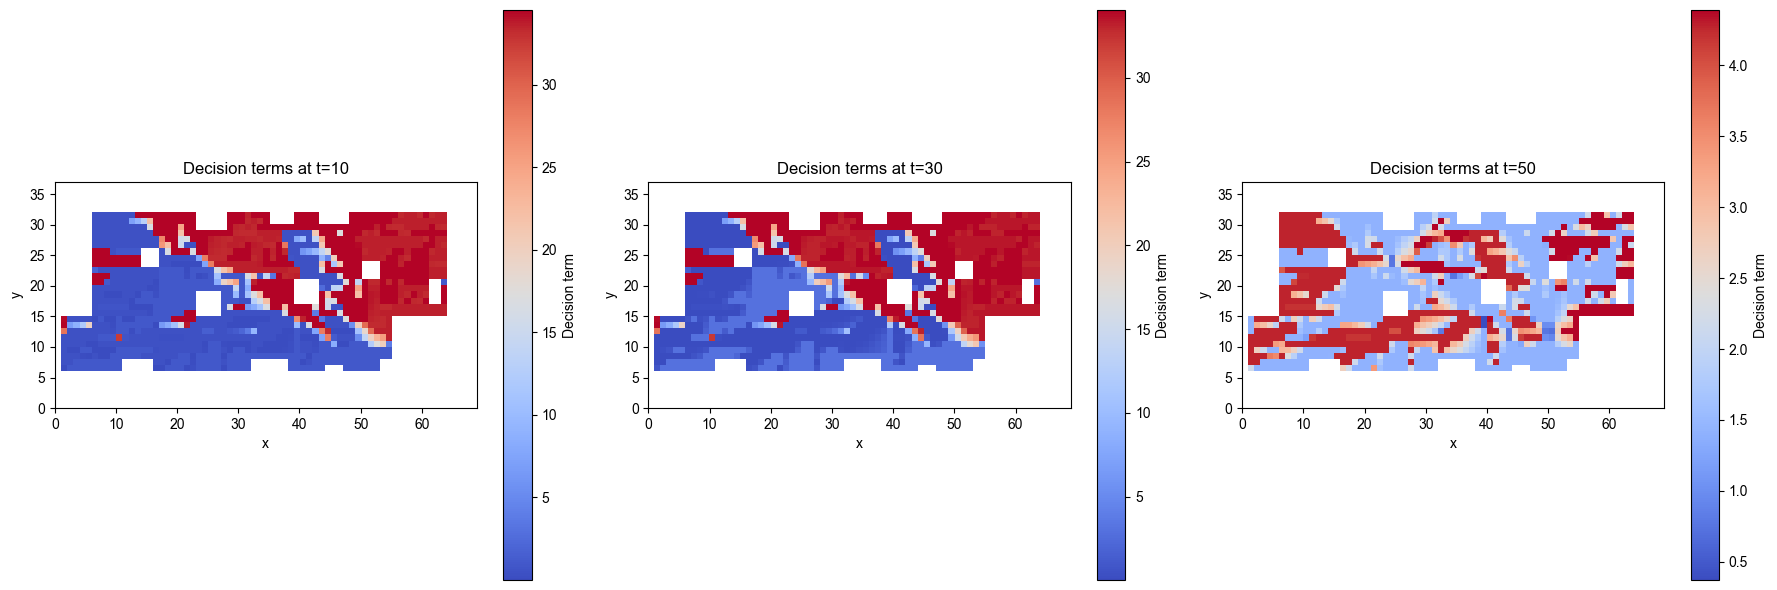

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, t in zip(axes, [10, 30, 50]):
    plot_decision_map(P, policy, state_map, t, ax=ax)

plt.tight_layout()
# plt.savefig('/Users/iuliarusu/Documents/museum/images/grant_images/decisioncomplexity.svg', format='svg', bbox_inches='tight')
plt.show()

In [36]:

def plot_decision_map(P, policy, state_map, t, ax=None, save_csv=True, outdir="."):
    """
    Compute and plot decision terms over the grid at time t.
    Also saves and returns a DataFrame with columns: [state, x, y, decision_term, t].
    """
    # --- compute decision term per state ---
    decision_vals = decision_term_map(P, policy, t)

    canonical_map = state_map.T
    W, H = canonical_map.shape
    grid = np.full((H, W), np.nan)

    rows = []  # will hold data for DataFrame
    for x in range(W):
        for y in range(H):
            s = canonical_map[x, y]
            if s in decision_vals:
                val = decision_vals[s]
                grid[y, x] = val
                rows.append({
                    "state": s,
                    "x": x,
                    "y": y,
                    "decision_term": val,
                    "t": t
                })

    # --- build DataFrame ---
    df = pd.DataFrame(rows)

    # --- optionally save ---
    if save_csv:
        csv_path = f"{outdir}/decision_terms_t{t}.csv"
        df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")

    # --- plotting ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(grid, origin="lower", cmap="coolwarm",
                   extent=[0, W, 0, H], interpolation="nearest", aspect="equal")
    ax.set_title(f"Decision terms at t={t}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(im, ax=ax, label="Decision term")

    return im, df


Saved: ./decision_terms_t10.csv
Saved: ./decision_terms_t30.csv
Saved: ./decision_terms_t50.csv


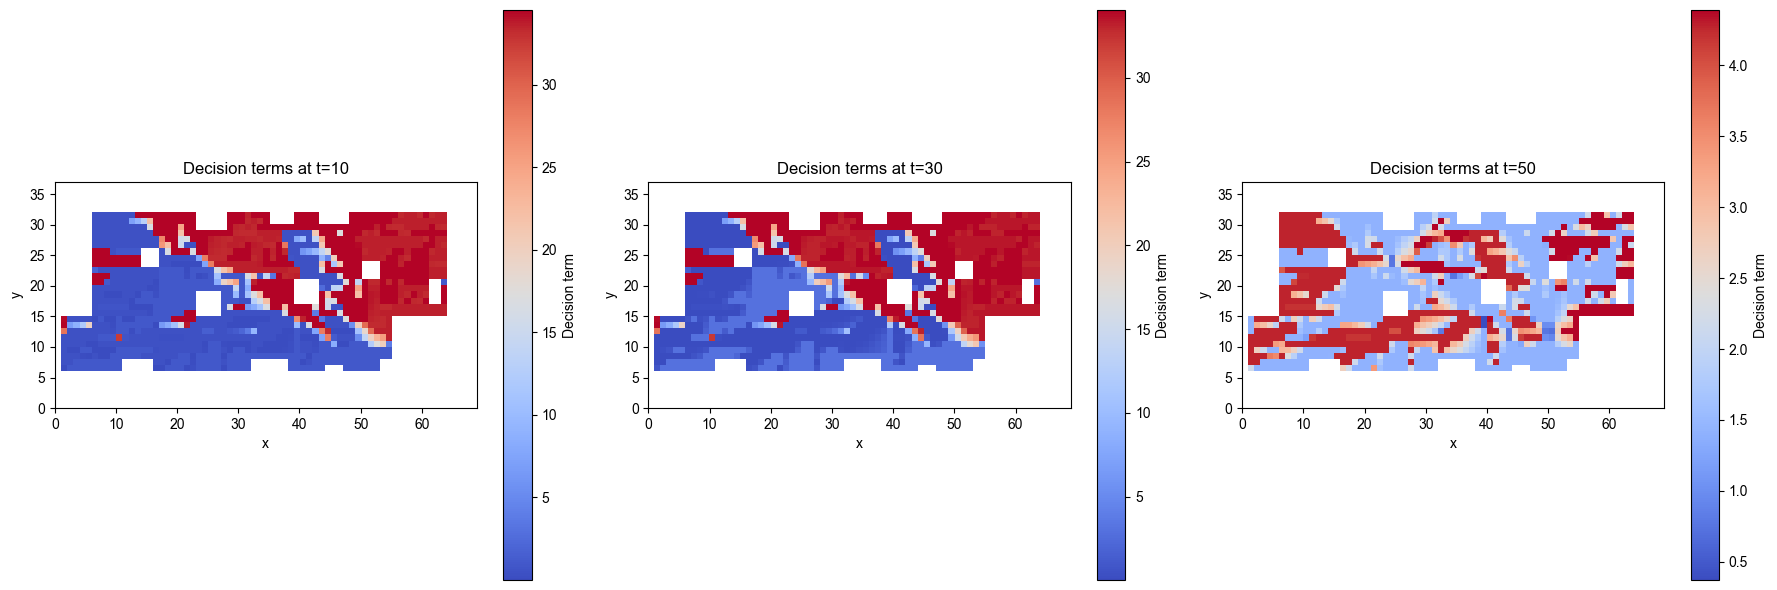

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
dfs = []  # to collect all time DataFrames

for ax, t in zip(axes, [10, 30, 50]):
    im, df_t = plot_decision_map(P, policy, state_map, t, ax=ax)
    dfs.append(df_t)

plt.tight_layout()
# plt.savefig('/Users/iuliarusu/Documents/museum/images/grant_images/decisionvreward.svg', format='svg', bbox_inches='tight')
plt.show()

In [139]:
dfs

[      state   x   y  decision_term   t
 0         0   1   6       0.042616  10
 1        38   1   7       0.433618  10
 2        79   1   8       0.433648  10
 3       133   1   9       0.433653  10
 4       187   1  10       0.433657  10
 ...     ...  ..  ..            ...  ..
 1347   1152  63  27      33.617106  10
 1348   1210  63  28      34.531624  10
 1349   1263  63  29      33.280775  10
 1350   1307  63  30      33.617106  10
 1351   1351  63  31      33.617106  10
 
 [1352 rows x 5 columns],
       state   x   y  decision_term   t
 0         0   1   6       0.809526  30
 1        38   1   7       0.051775  30
 2        79   1   8       0.051799  30
 3       133   1   9       0.051803  30
 4       187   1  10       0.051806  30
 ...     ...  ..  ..            ...  ..
 1347   1152  63  27      33.449751  30
 1348   1210  63  28      34.047182  30
 1349   1263  63  29      33.017587  30
 1350   1307  63  30      33.449751  30
 1351   1351  63  31      33.449751  30
 
 [1352 row

In [198]:
df_t

,state,x,y,decision_term,t
0,0,1,6,2.168650,50
1,38,1,7,4.269208,50
2,79,1,8,4.269247,50
3,133,1,9,4.269253,50
4,187,1,10,4.269258,50
...,...,...,...,...,...
1347,1152,63,27,4.390296,50
1348,1210,63,28,1.418795,50
1349,1263,63,29,2.879492,50
1350,1307,63,30,4.390296,50


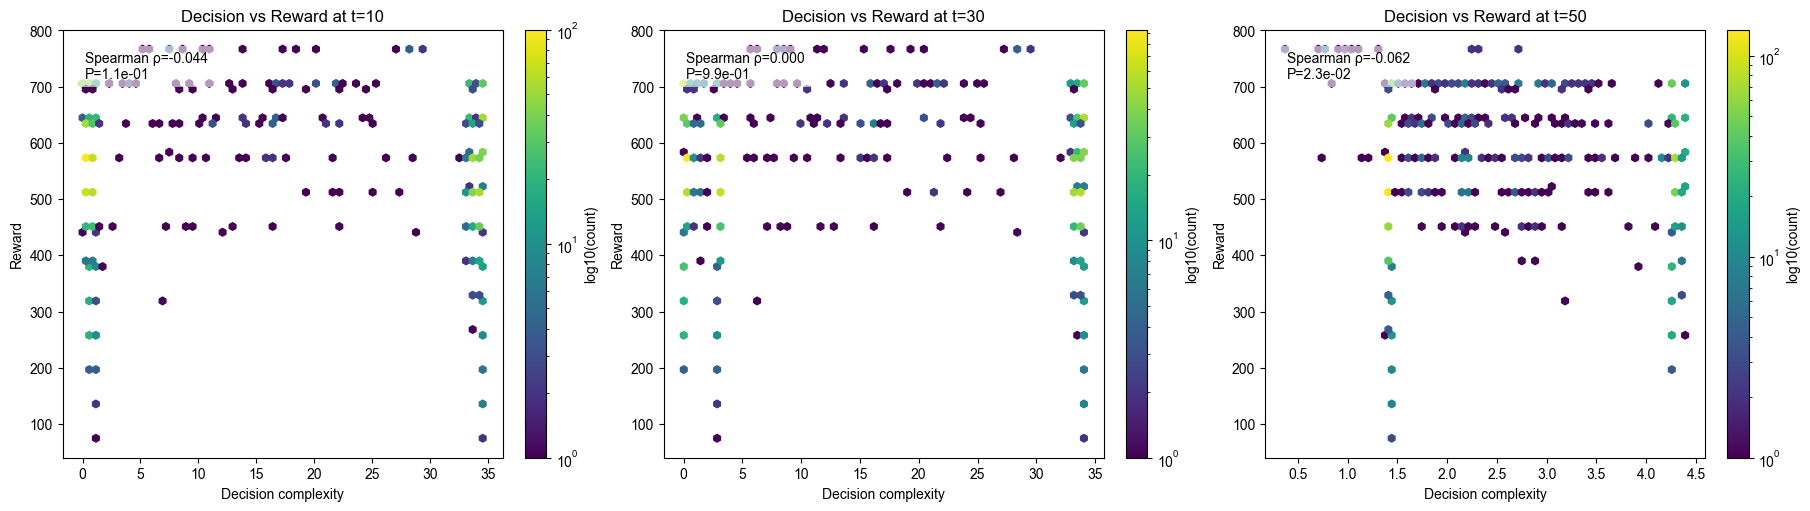

In [38]:

# ---- 1) Attach reward per state to each df_t ----
# rewards: your vector from MaxEnt IRL (length >= nstates)
nstates = int(state_map.max() + 1)
reward_states = np.asarray(rewards)[:nstates]  # reward per state id

# dfs is your list: [df_t10, df_t30, df_t50]
dfs_with_r = []
for df_t in dfs:  # each df_t has columns: state, x, y, decision_term, t
    d = df_t.copy()
    d['reward'] = reward_states[d['state'].values]
    # clean any NaNs/Infs if present
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=['decision_term','reward'])
    dfs_with_r.append(d)

# ---- 2) Plot decision complexity vs reward for the three times ----
fig, axes = plt.subplots(1, len(dfs_with_r), figsize=(6*len(dfs_with_r), 5), constrained_layout=True)

if len(dfs_with_r) == 1:
    axes = [axes]

for ax, d in zip(axes, dfs_with_r):
    tval = int(d['t'].iloc[0])  # the time for this df

    # density scatter for readability
    hb = ax.hexbin(d['decision_term'], d['reward'], gridsize=60, bins='log')
    plt.colorbar(hb, ax=ax, label='log10(count)')

    # Spearman annotation
    rho, p = spearmanr(d['decision_term'], d['reward'], nan_policy='omit')
    ax.text(0.05, 0.95, f"Spearman ρ={rho:.3f}\nP={p:.1e}", transform=ax.transAxes,
            va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.set_xlabel('Decision complexity')
    ax.set_ylabel('Reward')
    ax.set_title(f'Decision vs Reward at t={tval}')
# plt.savefig('/Users/iuliarusu/Documents/museum/images/grant_images/decisionvreward.svg', format='svg', bbox_inches='tight')
plt.show()


In [39]:

for d in dfs_with_r:
    tval = int(d['t'].iloc[0])
    d['decision_sq'] = d['decision_term']**2
    model = smf.ols('reward ~ decision_term + decision_sq', data=d).fit()
    print(f"t={tval}:")
    print(model.summary().tables[1])

t=10:
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       539.5098      4.982    108.302      0.000     529.737     549.282
decision_term    14.1216      1.677      8.422      0.000      10.832      17.411
decision_sq      -0.4150      0.048     -8.655      0.000      -0.509      -0.321
t=30:
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       537.1255      5.376     99.917      0.000     526.580     547.671
decision_term    11.8387      1.642      7.208      0.000       8.617      15.061
decision_sq      -0.3491      0.047     -7.448      0.000      -0.441      -0.257
t=50:
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

# speed v decision complexity

In [40]:
dfs_with_speed = []
for df_t in dfs:  # your decision complexity DataFrames
    tval = int(df_t['t'].iloc[0])
    
    # merge speed + decision term by state
    merged = pd.merge(speeds, df_t[['state', 'decision_term']], on='state', how='inner')
    
    # store time info
    merged['t'] = tval
    merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['inst_speed', 'decision_term'])
    
    dfs_with_speed.append(merged)

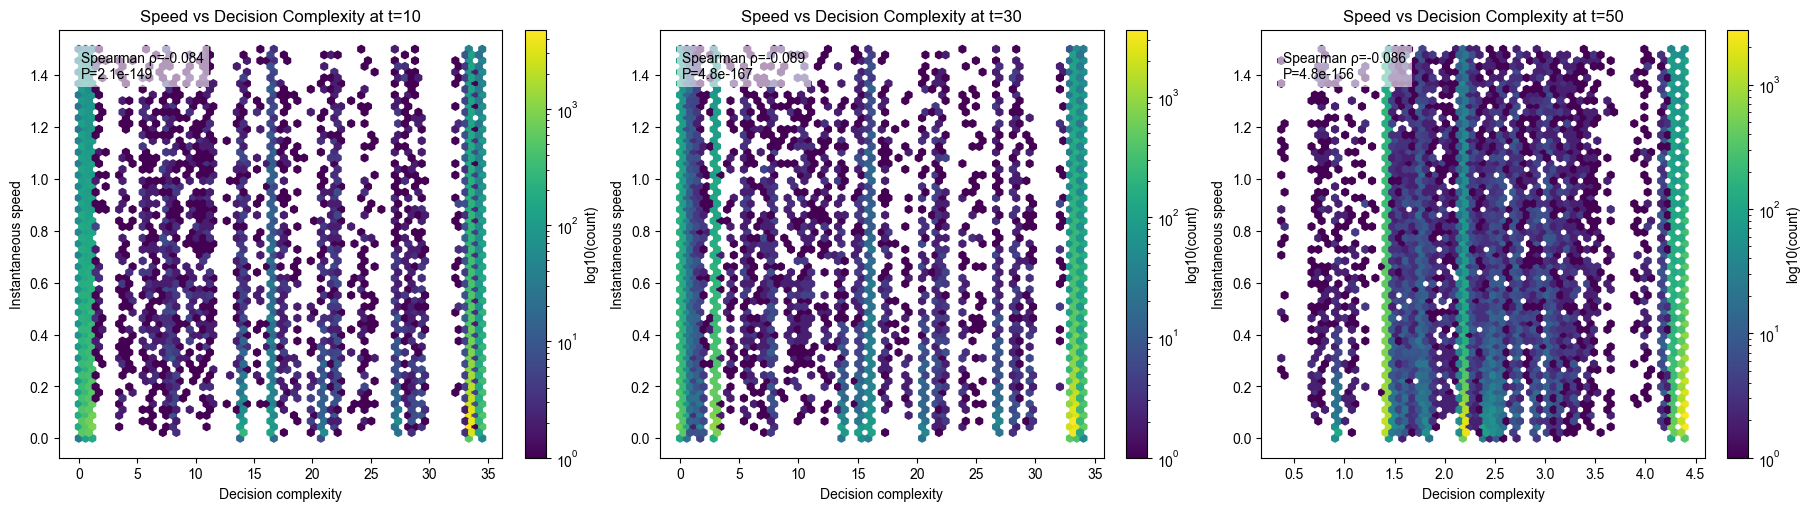

In [41]:
fig, axes = plt.subplots(1, len(dfs_with_speed), figsize=(6*len(dfs_with_speed), 5), constrained_layout=True)

if len(dfs_with_speed) == 1:
    axes = [axes]

for ax, d in zip(axes, dfs_with_speed):
    tval = int(d['t'].iloc[0])
    
    hb = ax.hexbin(d['decision_term'], d['inst_speed'], gridsize=60, bins='log')
    plt.colorbar(hb, ax=ax, label='log10(count)')
    
    rho, p = spearmanr(d['decision_term'], d['inst_speed'], nan_policy='omit')
    ax.text(0.05, 0.95, f"Spearman ρ={rho:.3f}\nP={p:.1e}", transform=ax.transAxes,
            va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    ax.set_xlabel('Decision complexity')
    ax.set_ylabel('Instantaneous speed')
    ax.set_title(f'Speed vs Decision Complexity at t={tval}')
# plt.savefig('/Users/iuliarusu/Documents/museum/images/grant_images/speedvdecision.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
# plot decision terms over 

In [ ]:
# check correlation between reward and speed, does 